In [1]:
import torch
import sklearn
import numpy as np
import deep_cluster.dataloader
from deep_cluster.dataloader import smooth
from pathlib import Path
import deep_cluster
import pandas as pd
from matplotlib import pyplot as plt
from landmarks_video import LandmarksVideo
from gui import Animation
import cv2 as cv
from PIL import Image
from scipy import signal as sig
import tkinter as tk
from PIL import ImageTk, Image

In [2]:
# video_file = Path('/home/orel/Storage/Data/K7/2020-08-05/Down/0037.MP4')
video_dir = Path('/home/orel/Storage/Data/K7/2020-08-05/Down')
video = LandmarksVideo(video_dir, smooth=True)
df = video.landmarks.df
body_parts = video.landmarks.body_parts
body_parts = body_parts[~(body_parts == 'tail2')]

In [3]:
df['confidence'] = np.prod(np.stack([df[bp].likelihood.values for bp in body_parts]), axis=0)
# high_confidence_bool = np.logical_and(df.confidence > 0.99, smooth(df.confidence, lpf_freq=1.0, fs=video.fps) > 0.99)
idxs = np.where(df.confidence > 0.95)[0]
segments = np.split(idxs, np.where(np.diff(idxs) > 1)[0] + 1)
segments = [seg for seg in segments if len(seg) > 120 * 1]

In [4]:
sum([len(seg) for seg in segments])

150480

<ipython-input-30-4ab99ddf284c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(body_parts)


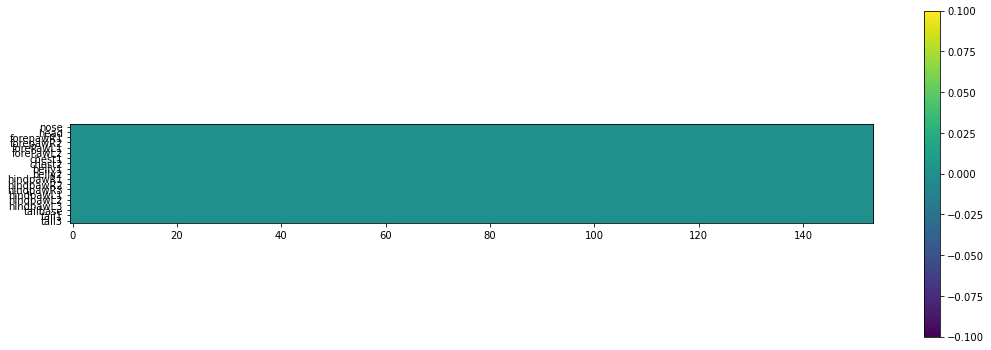

In [30]:
def find_outliers(data, hpf_freq=30, fs=240):
    cutoff = fs / hpf_freq
    filt = sig.butter(4, hpf_freq, btype='high', output='ba', fs=fs)
    filtered = sig.filtfilt(*filt, data)
    return np.abs(filtered) > cutoff
to_slice = lambda seg: slice(seg[0], seg[-1])
outliers = [{bp: np.mean(find_outliers(df[bp].x.iloc[to_slice(seg)], fs=120)) for bp in body_parts} for seg in segments]
# outliers = [{k: v for k, v in outlier.items() if v > 0} for outlier in outliers]
outliers_mat = np.zeros((len(body_parts), len(segments)))
for i, bp in enumerate(body_parts):
    for j, seg in enumerate(segments):
        outliers_mat[i, j] = outliers[j][bp]
fig, axis = plt.subplots(figsize=(18, 6))
axis.imshow(outliers_mat)
axis.set_yticklabels(body_parts)
axis.set_yticks(range(len(body_parts)))
plt.colorbar(axis.images[0], ax=axis)

In [5]:
root = tk.Tk()
for i in range(20, 25):
    seg_start = segments[i][0]
    idx = slice(seg_start, seg_start + 120, 1)
    anim = Animation(root, video[idx])
    anim.pack(side=tk.LEFT)
root.mainloop()

In [6]:
def write(vid, file, fps):
    n_frames, width, height, _ = vid.shape
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    writer = cv.VideoWriter(str(file), fourcc, fps, (height, width), True)
    for frame in vid:
        writer.write(frame)
    writer.release()

# write(vid, '/home/orel/Storage/shuki/projects/videos/video.mp4', video.fps // 4)

In [7]:
import os

frame_to_time = lambda idx: f'{idx // (video.fps*60)}-{(idx % (video.fps*60)) // video.fps}'
save_dir = Path('/home/orel/Storage/shuki/projects/videos/0038_2')
os.makedirs(save_dir, exist_ok=True)
MAX_LEN = 2000
import os
idx = 0
for i, seg in enumerate(segments):
    print(i)
    seg = np.array(seg)
    for sub_seg in np.array_split(seg, len(seg) // MAX_LEN + 1):
        save_file = save_dir / f'time_{frame_to_time(sub_seg[0])}_{frame_to_time(sub_seg[-1])}.mp4'
        if os.path.exists(save_file):
            idx += 1
            continue
        vid = video[sub_seg[0]: sub_seg[-1]: 2]
        write(vid, save_file, video.fps // 4)
        idx += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


In [1]:
for seg in segments:
    print(len(seg))

NameError: name 'segments' is not defined

In [1]:
Image.fromarray(video[segments[32][10]])

NameError: name 'Image' is not defined

<AxesSubplot:xlabel='index'>

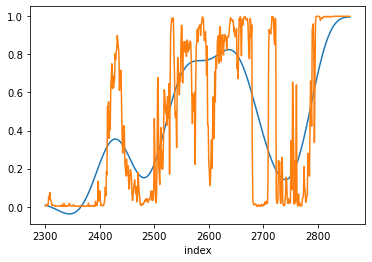

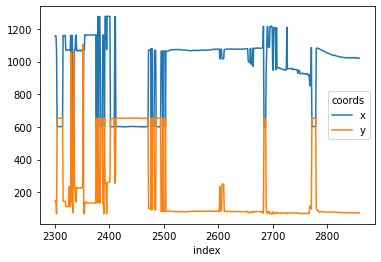

In [32]:
from scipy import signal as sig
def smooth(data, lpf_freq=1, fs=120):
    filt = sig.butter(4, lpf_freq, btype='low', output='ba', fs=fs)
    filtered = sig.filtfilt(*filt, data)
    return filtered

plt.plot(range(2300, 2860), smooth(video.landmarks.df.iloc[slice(2300, 2860)]['tail3']['likelihood'].values))
video.landmarks.df.iloc[slice(2300, 2860)]['tail3']['likelihood'].plot()
video.landmarks.df.iloc[slice(2300, 2860)]['tail3'][['x', 'y']].plot()